# Product Back Order classification Problem

## 1. Import Libraries

In [29]:
# For EDA and Preprocessing
import pandas as pd
import numpy as np
import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt 
import time
import warnings
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler,LabelEncoder, OrdinalEncoder,RobustScaler

# For pipeline 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# For Prediction
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC  

# For Inference
import joblib
 
warnings.filterwarnings('ignore')

## 2. Load Datasets

In [2]:
train = pd.read_csv('./Datasets/Kaggle_Training_Dataset_v2.csv',sep=',')
test = pd.read_csv('./Datasets/Kaggle_Test_Dataset_v2.csv',sep=',')

In [3]:
train.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


In [4]:
test.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,3285085,62.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
1,3285131,9.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,Yes,No,No,No
2,3285358,17.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.92,0.95,0.0,No,No,No,Yes,No,No
3,3285517,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.78,0.75,0.0,No,No,Yes,Yes,No,No
4,3285608,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.54,0.71,0.0,No,No,No,Yes,No,No


In [5]:
# Combine two datasets
combined_dataset = pd.concat([train,test],ignore_index=True)
# Check the completeness 
assert (train.shape[0]+test.shape[0])==combined_dataset.shape[0]

## 3. Exporatory Data Analysis (EDA)

### 3.1 Data Consideration
This process will consider about the data cleaning to ensure the quality, integrity, and usefulness of data.

In [6]:
# Check combined dataset
combined_dataset.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


In [7]:
# Check dataset shape
combined_dataset.shape

(1929937, 23)

In [8]:
# Check dataset columns
combined_dataset.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

In [9]:
# Check dataset features type
combined_dataset.dtypes

sku                   object
national_inv         float64
lead_time            float64
in_transit_qty       float64
forecast_3_month     float64
forecast_6_month     float64
forecast_9_month     float64
sales_1_month        float64
sales_3_month        float64
sales_6_month        float64
sales_9_month        float64
min_bank             float64
potential_issue       object
pieces_past_due      float64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty         float64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

In [10]:
# Checking numerical and categorical features
numerical_cols = []
categorical_cols = []

for column in combined_dataset.columns:
    if pd.api.types.is_numeric_dtype(combined_dataset[column]):
        numerical_cols.append(column)
    else:
        categorical_cols.append(column)

print(f'Numerical Features: {len(numerical_cols)} ,{numerical_cols}')     
print(f'Categorical Features: {len(categorical_cols)} ,{categorical_cols}')     

Numerical Features: 15 ,['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty']
Categorical Features: 8 ,['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']


In [11]:
# Redefined categorial features (we not used 'sku' which is product ID features)
categorical_cols.remove('sku') 

In [12]:
# Describe the combined dataset
combined_dataset.describe()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,1.929935e+06,1.814318e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06
mean,4.965683e+02,7.878627e+00,4.306440e+01,1.785399e+02,3.454659e+02,5.066067e+02,5.536816e+01,1.746639e+02,3.415653e+02,5.235771e+02,5.277637e+01,2.016193e+00,-6.899870e+00,-6.462343e+00,6.537039e-01
std,2.957343e+04,7.054212e+00,1.295420e+03,5.108770e+03,9.831562e+03,1.434543e+04,1.884377e+03,5.188856e+03,9.585030e+03,1.473327e+04,1.257968e+03,2.296112e+02,2.659988e+01,2.588343e+01,3.543230e+01
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.300000e-01,6.600000e-01,0.000000e+00
50%,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,8.200000e-01,8.100000e-01,0.000000e+00
75%,8.000000e+01,9.000000e+00,0.000000e+00,4.000000e+00,1.200000e+01,2.000000e+01,4.000000e+00,1.500000e+01,3.100000e+01,4.700000e+01,3.000000e+00,0.000000e+00,9.600000e-01,9.500000e-01,0.000000e+00
max,1.233440e+07,5.200000e+01,4.894080e+05,1.510592e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,3.133190e+05,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04


Features 'perf_6_month_avg' and 'perf_12_month_avg' have the -99.0 which seem to be missing values and filled with -99.0

In [13]:
# Counts -99.0 in feature 'perf_6_month_avg'
combined_dataset['perf_6_month_avg'].value_counts()

 0.99     163323
 1.00     150339
-99.00    148579
 0.73     128818
 0.98      97390
           ...  
 0.20        921
 0.03        829
 0.04        724
 0.01        648
 0.29        572
Name: perf_6_month_avg, Length: 102, dtype: int64

In [14]:
# Counts -99.0 in feature 'perf_12_month_avg'
combined_dataset['perf_12_month_avg'].value_counts()

 0.99     152682
-99.00    140025
 0.78     131353
 0.98     106119
 0.97      74113
           ...  
 0.23        895
 0.06        873
 0.05        743
 0.03        639
 0.02        437
Name: perf_12_month_avg, Length: 102, dtype: int64

In [15]:
# Check Missing Values in combined_dataset
combined_dataset.isna().sum()

sku                       0
national_inv              2
lead_time            115619
in_transit_qty            2
forecast_3_month          2
forecast_6_month          2
forecast_9_month          2
sales_1_month             2
sales_3_month             2
sales_6_month             2
sales_9_month             2
min_bank                  2
potential_issue           2
pieces_past_due           2
perf_6_month_avg          2
perf_12_month_avg         2
local_bo_qty              2
deck_risk                 2
oe_constraint             2
ppap_risk                 2
stop_auto_buy             2
rev_stop                  2
went_on_backorder         2
dtype: int64

There might be 2 rows that contains all missing values. Let's check that..

In [16]:
# Check for all missing rows
combined_dataset[combined_dataset['went_on_backorder'].isna()]

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1687860,(1687860 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1929936,(242075 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Check that missing rows are contain all missing values
combined_dataset[combined_dataset['went_on_backorder'].isna()].all()

sku                  True
national_inv         True
lead_time            True
in_transit_qty       True
forecast_3_month     True
forecast_6_month     True
forecast_9_month     True
sales_1_month        True
sales_3_month        True
sales_6_month        True
sales_9_month        True
min_bank             True
potential_issue      True
pieces_past_due      True
perf_6_month_avg     True
perf_12_month_avg    True
local_bo_qty         True
deck_risk            True
oe_constraint        True
ppap_risk            True
stop_auto_buy        True
rev_stop             True
went_on_backorder    True
dtype: bool

In [18]:
# Drop 2 missing rows
combined_dataset.drop(combined_dataset[combined_dataset['sku'] == '(1687860 rows)'].index,inplace=True)
combined_dataset.drop(combined_dataset[combined_dataset['sku'] == '(242075 rows)'].index,inplace=True)

In [19]:
# Recheck missing rows again
combined_dataset.isna().sum()

sku                       0
national_inv              0
lead_time            115617
in_transit_qty            0
forecast_3_month          0
forecast_6_month          0
forecast_9_month          0
sales_1_month             0
sales_3_month             0
sales_6_month             0
sales_9_month             0
min_bank                  0
potential_issue           0
pieces_past_due           0
perf_6_month_avg          0
perf_12_month_avg         0
local_bo_qty              0
deck_risk                 0
oe_constraint             0
ppap_risk                 0
stop_auto_buy             0
rev_stop                  0
went_on_backorder         0
dtype: int64

In [20]:
# LabelEncoder the target features
target_col = LabelEncoder().fit_transform(combined_dataset['went_on_backorder'])
combined_dataset['went_on_backorder']= target_col

### 3.2 Univariate Analysis

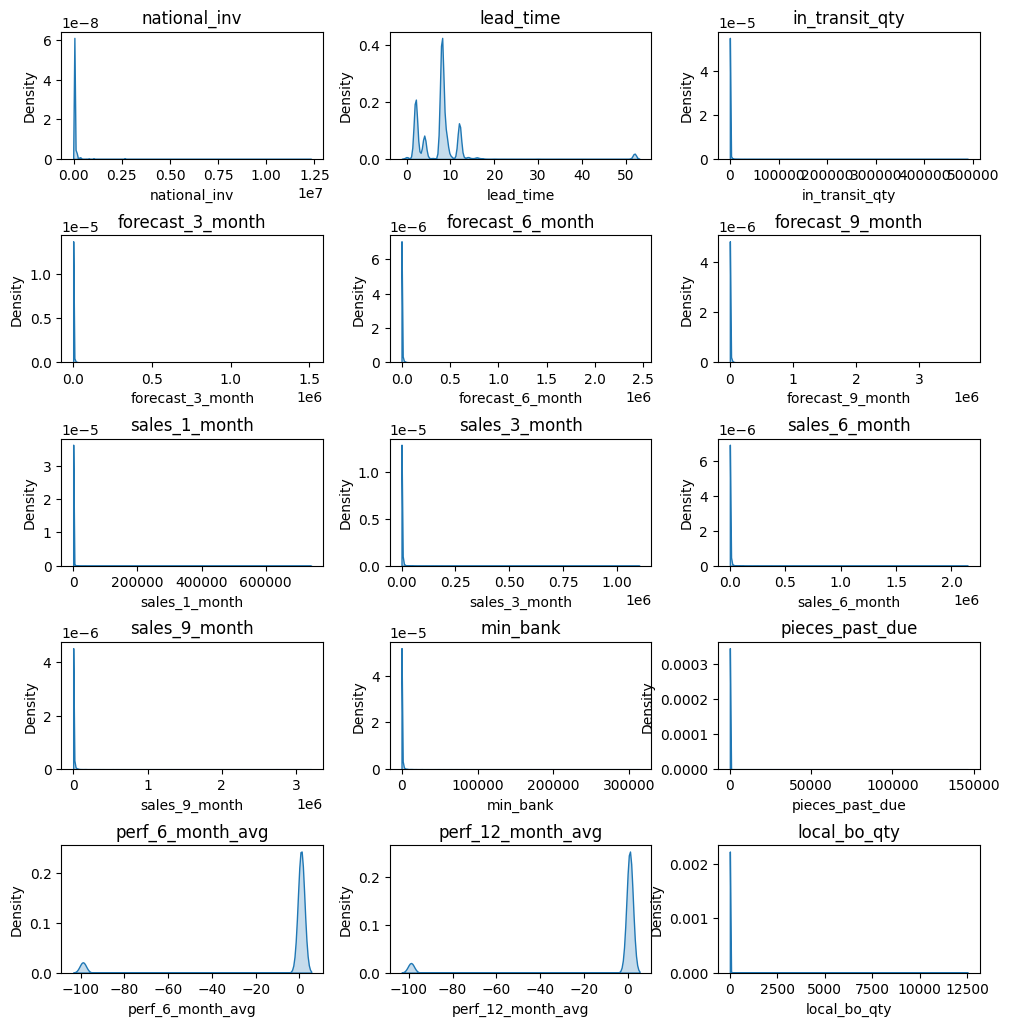

In [21]:
# Check the skrew of data
# Create subplots for kde plots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 10))
fig.tight_layout()

# Iterate through the list and create kde plots
for i, k in enumerate(numerical_cols):
    row, col = divmod(i, 3)
    sns.kdeplot(data = combined_dataset,x=k, fill=True, ax=axes[row, col])
    axes[row, col].set_title(k)
plt.subplots_adjust(hspace=0.6)
plt.show()

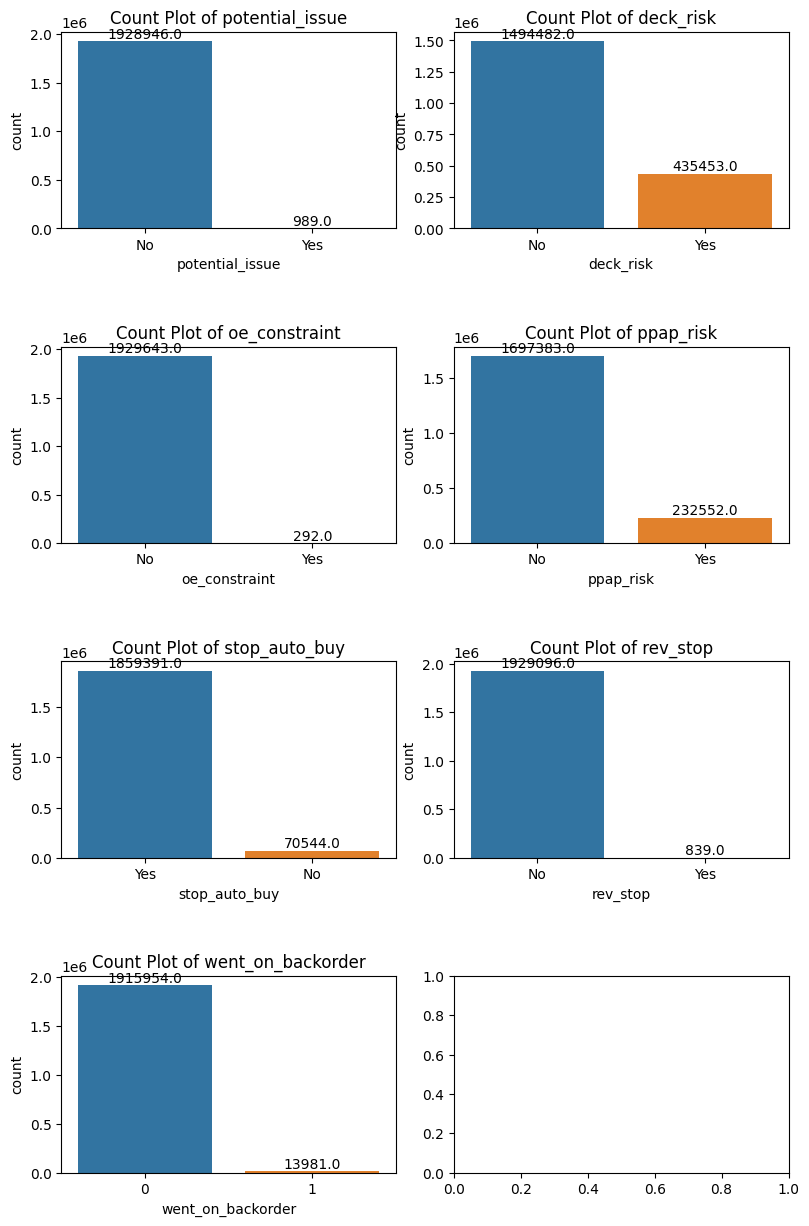

In [22]:
# Countplot for categorical features
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 12))
fig.tight_layout()

# Iterate through the list of categorical features and create count plots
for i, feature in enumerate(categorical_cols):
    row, col = divmod(i, 2)
    ax = sns.countplot(data=combined_dataset, x=feature, ax=axes[row, col])
     # Add count annotations above each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')
    axes[row, col].set_title(f'Count Plot of {feature}')
plt.subplots_adjust(hspace=0.6)
plt.show()

### 3.3 Multivariate Analysis

In [23]:
#Calculate the outliers 
def outlier_count(col, data):
    
    # calculate your 25% quatile and 75% quatile
    q75, q25 = np.percentile(data[col], [75, 25])
    
    # calculate your inter quatile
    iqr = q75 - q25
    
    # min_val and max_val
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    
    # count number of outliers, which are the data that are less than min_val or more than max_val calculated above
    outlier_count = len(np.where((data[col] > max_val) | (data[col] < min_val))[0])
    
    # calculate the percentage of the outliers
    outlier_percent = round(outlier_count/len(data[col])*100, 2)
    
    if(outlier_count > 0):
        print("\n"+15*'-' + col + 15*'-'+"\n")
        print('Number of outliers: {}'.format(outlier_count))
        print('Percent of data that is outlier: {}%'.format(outlier_percent))

    col_list = list(data[col])
    col_list.sort()
    #for 90 to 100 percentile
    for i in range(90,101,1):
        print(i,'percentile value is',np.percentile(col_list,i))
    #for 99.0 to 100 percentile
    col_list=list(data[col])
    col_list.sort()
    for i in np.arange(0.0,1.0,0.1):
        print('{}percentile value is {}'.format(99+i,col_list[int(len(col_list)*(float(99+i)/100))]))
    print("100 percentile value is ",col_list[-1])
    

In [24]:
#Loop the outliers function to find the percent of data that is outliers
for col in combined_dataset[numerical_cols]:
    outlier_count(col,combined_dataset)


---------------national_inv---------------

Number of outliers: 290377
Percent of data that is outlier: 15.05%
90 percentile value is 360.0
91 percentile value is 417.0
92 percentile value is 490.0
93 percentile value is 577.0
94 percentile value is 722.0
95 percentile value is 924.0
96 percentile value is 1225.0
97 percentile value is 1821.0
98 percentile value is 3015.0
99 percentile value is 5487.0
100 percentile value is 12334404.0
99.0percentile value is 5487.0
99.1percentile value is 6102.0
99.2percentile value is 6910.0
99.3percentile value is 7984.0
99.4percentile value is 9360.0
99.5percentile value is 11079.0
99.6percentile value is 13650.0
99.7percentile value is 17309.0
99.8percentile value is 24574.0
99.9percentile value is 41298.0
100 percentile value is  12334404.0
90 percentile value is nan
91 percentile value is nan
92 percentile value is nan
93 percentile value is nan
94 percentile value is nan
95 percentile value is nan
96 percentile value is nan
97 percentile value

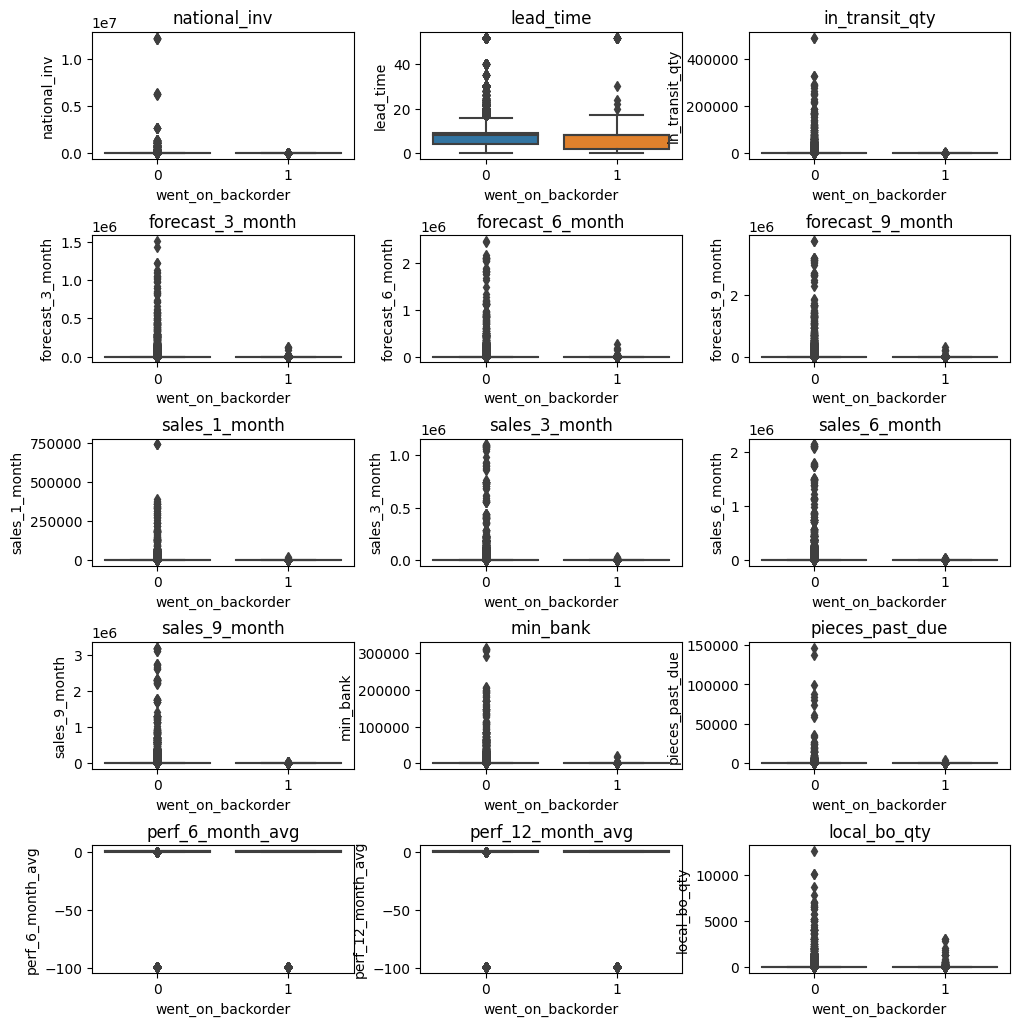

In [25]:
# Visulized the outliers
# Create subplots for box plots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 10))
fig.tight_layout()

# Iterate through the list and create box plots
for i, k in enumerate(numerical_cols):
    row, col = divmod(i, 3)
    sns.boxplot(x='went_on_backorder',y=k, data = combined_dataset, ax=axes[row, col])
    axes[row, col].set_title(k)
plt.subplots_adjust(hspace=0.6)
plt.show()

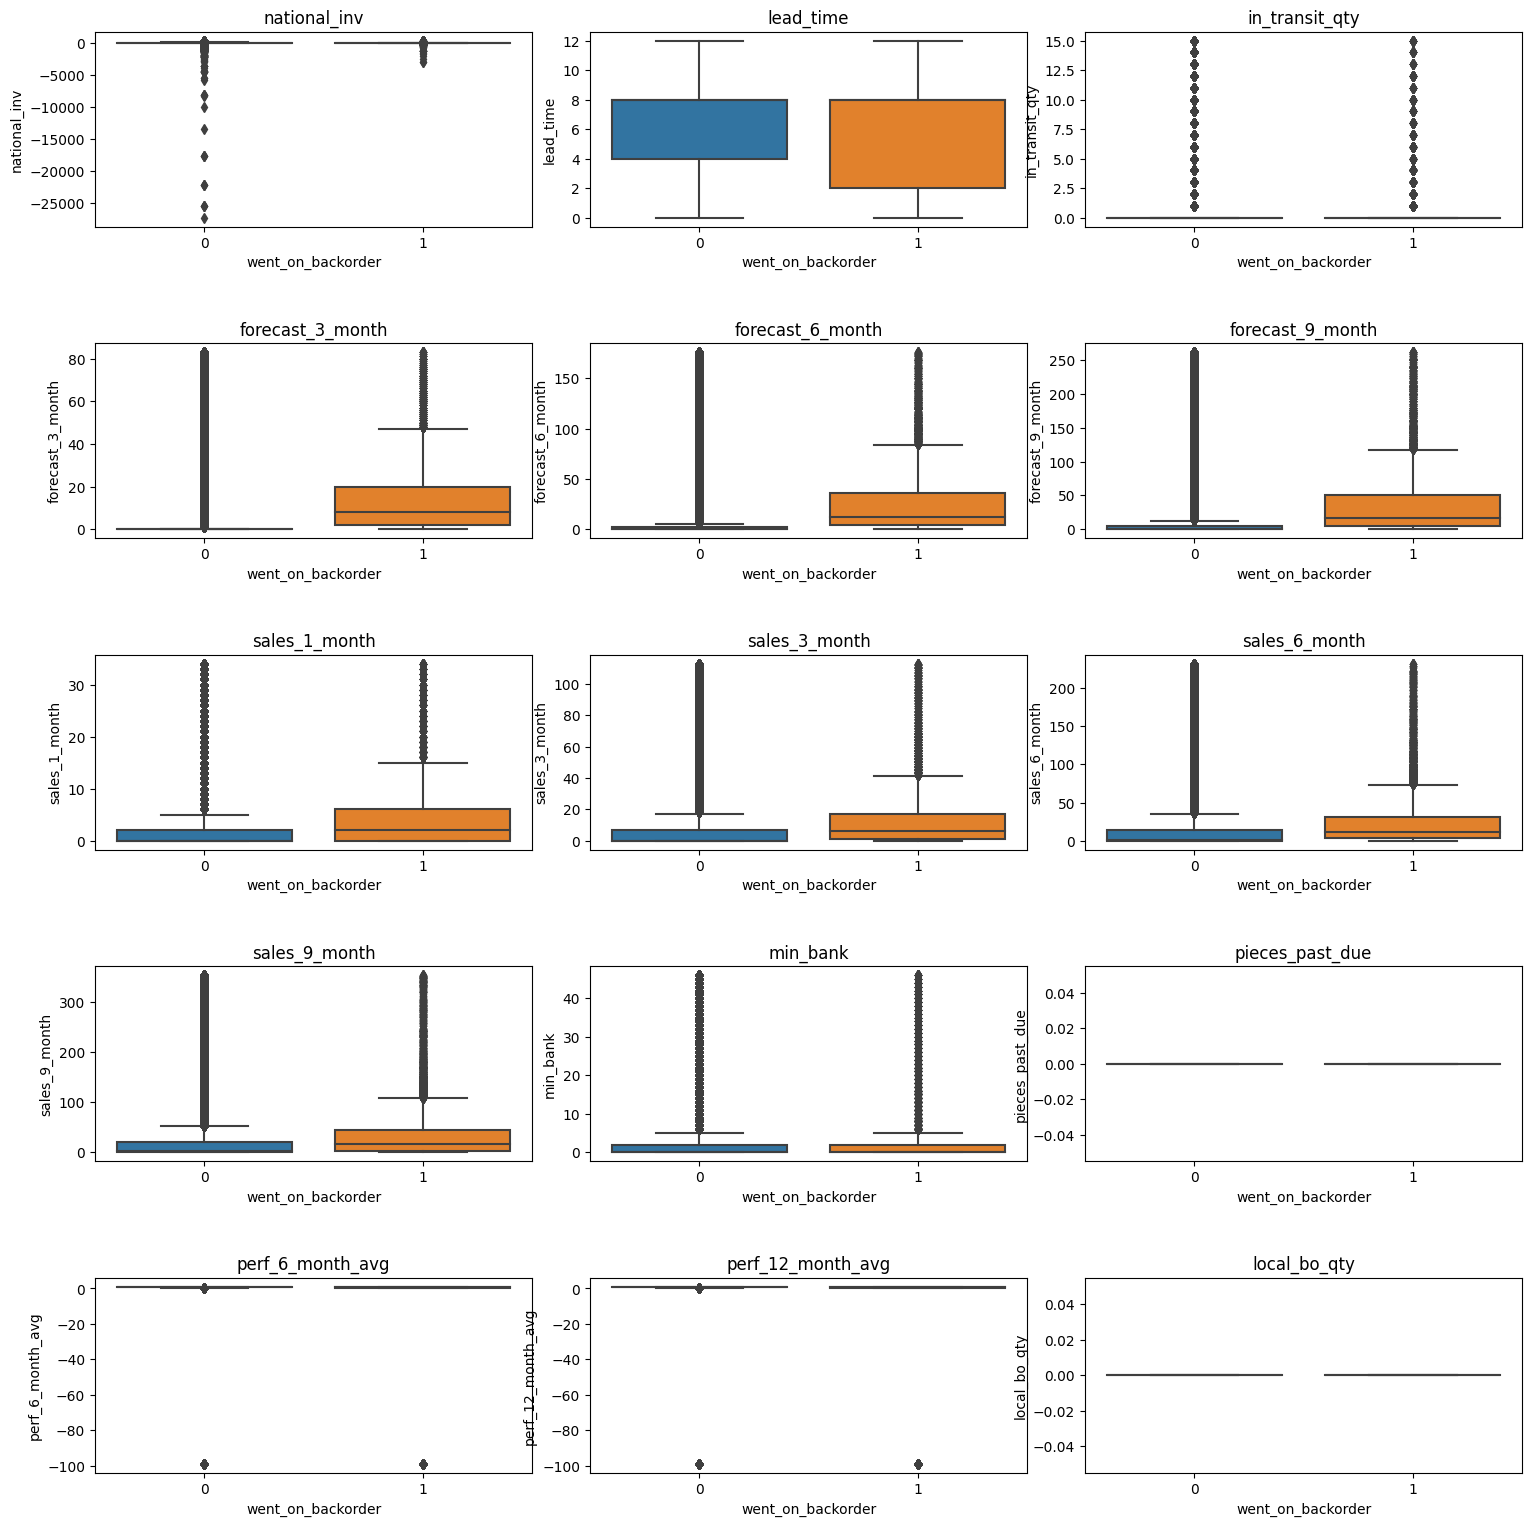

In [26]:
# Create subplots for box plots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
fig.tight_layout()

# Iterate through numerical columns and create box plots within the percentile range
for i, k in enumerate(numerical_cols):
    row, col = divmod(i, 3)
    zero_percentile_k = combined_dataset[k].quantile(0)
    ninety_percentile_k = combined_dataset[k].quantile(0.9)
    
    # Filter 'k' column based on its own percentile range 
    filtered_data_k = combined_dataset[(combined_dataset[k] >= zero_percentile_k) & 
                                    (combined_dataset[k] <= ninety_percentile_k)]
    
    sns.boxplot(x='went_on_backorder', y=k, data=filtered_data_k, ax=axes[row, col])
    axes[row, col].set_title(k)
plt.subplots_adjust(hspace=0.6)
plt.show()

<Axes: >

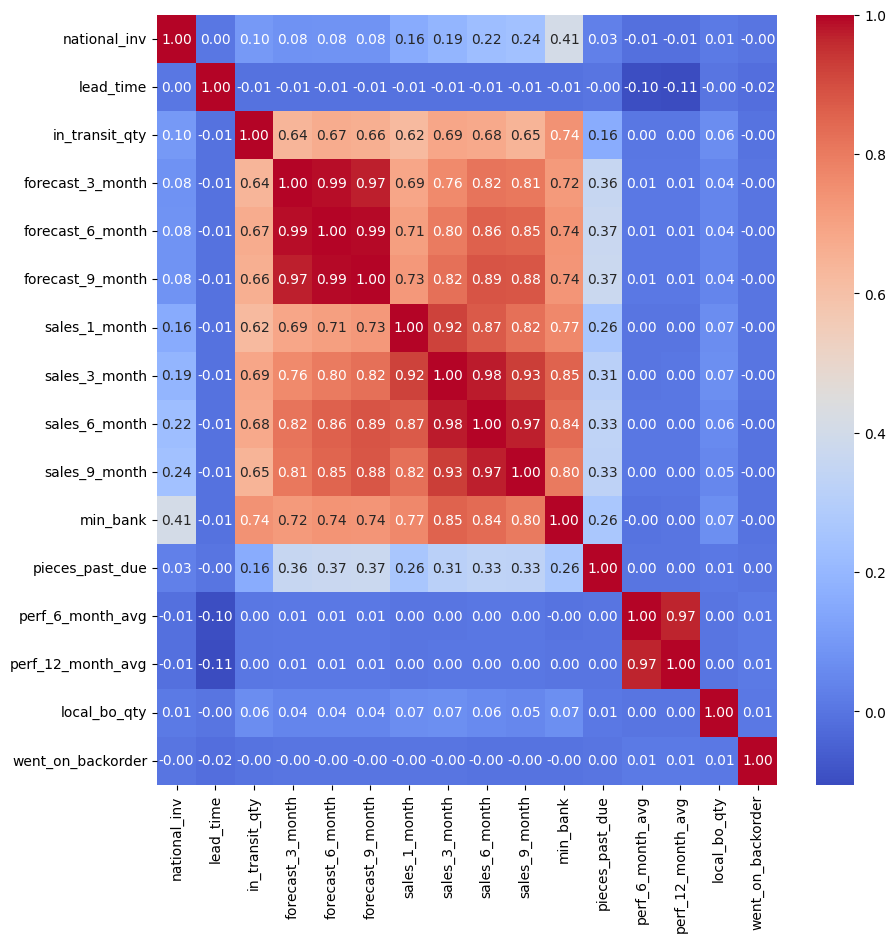

In [27]:
# Correlation Matrix 
plt.figure(figsize=(10,10))
sns.heatmap(combined_dataset.corr(), fmt=".2f", annot=True, cmap="coolwarm")

<Axes: xlabel='x', ylabel='y'>

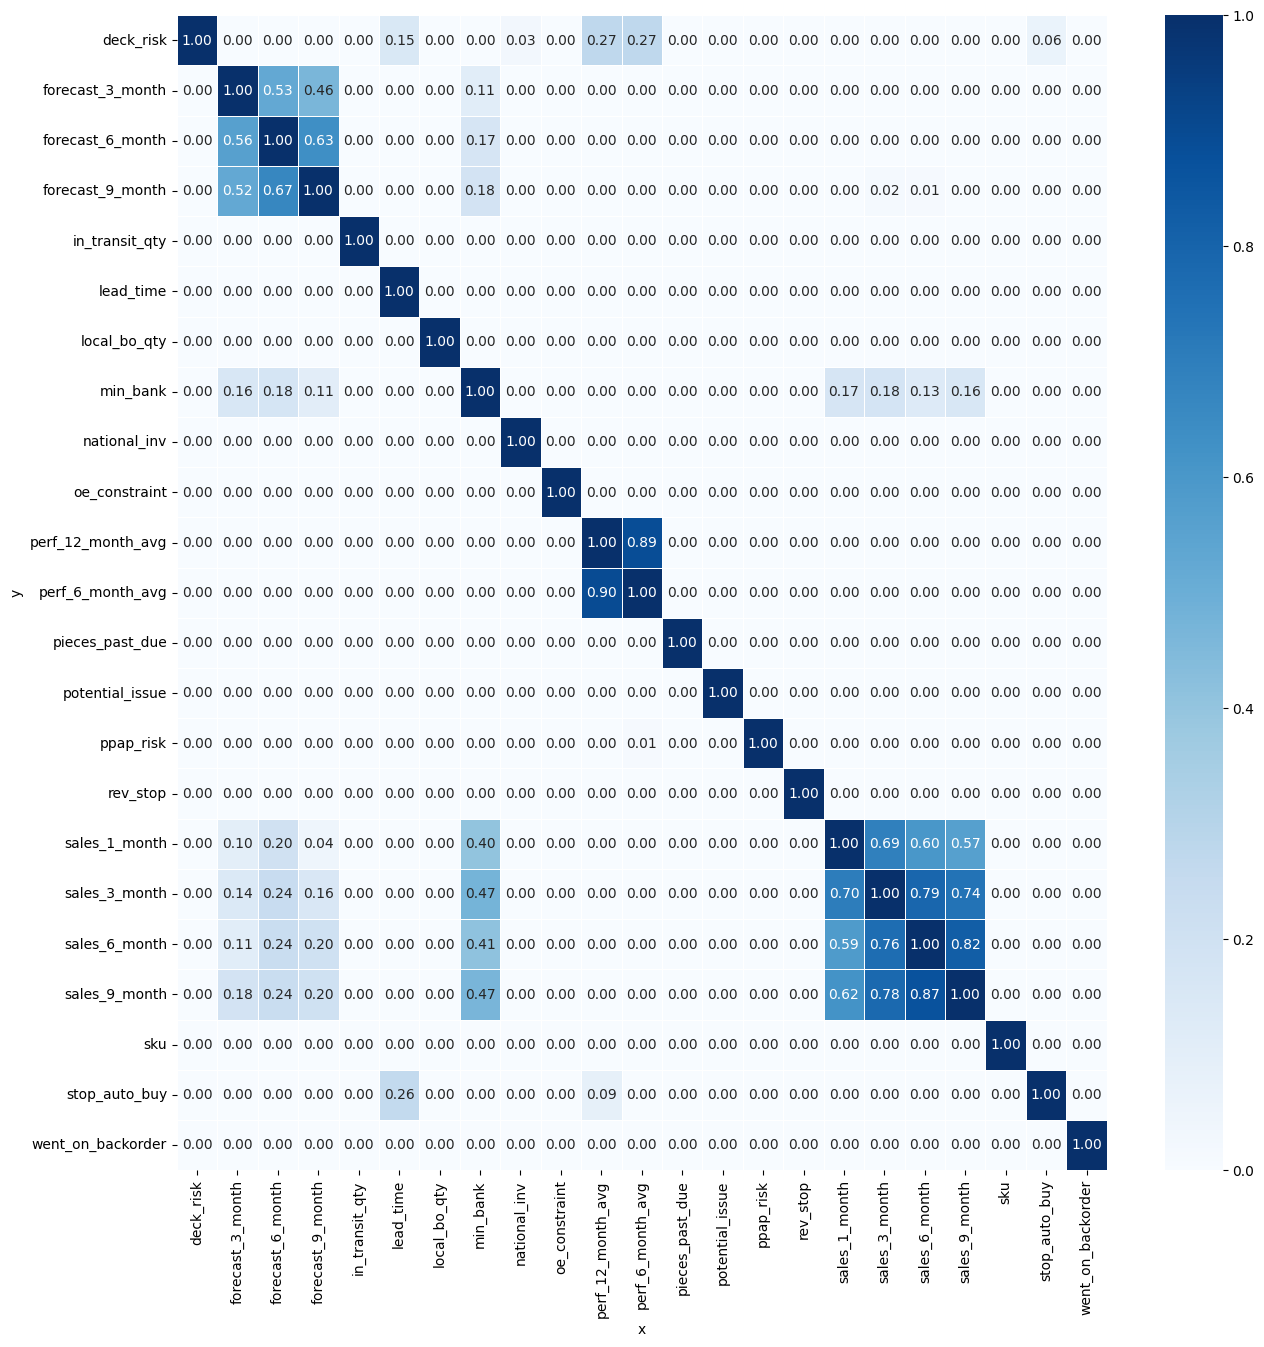

In [28]:
# Predictive Power Score
#Create another dataframe to used with pps (just in case that adjusting the features for this)
df_pps=combined_dataset.copy()
matrix_df_pps = pps.matrix(df_pps)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
plt.figure(figsize=(15,15))
sns.heatmap(matrix_df_pps, vmin=0, vmax=1, fmt=".2f", cmap="Blues", linewidths=0.5, annot=True)

### 3.4 Features Selection
The features to be dropped are as follows: 'forecast_3_month', 'forecast_6_month', 'forecast_9_month', and 'sku'. These forecast-related features exhibit high correlation (1.0), suggesting potential redundancy or a linear prediction relationship. Additionally, not all merchants may possess the capability to predict 'forecast_3_month', 'forecast_6_month', and 'forecast_9_month'. Furthermore, 'sku' represents the product ID and will be removed as well.

## 4. Preprocessing

### 4.1 Train and Test Split

In [311]:
# Setting dropped columns list
drop_cols = ['went_on_backorder','forecast_3_month','forecast_3_month','forecast_6_month','forecast_9_month','sku']

In [312]:
# Assign the X,y
X = combined_dataset.drop(columns=drop_cols)
y= pd.DataFrame(combined_dataset['went_on_backorder'])

In [313]:
# Checking y after unsampling
y.value_counts()

went_on_backorder
0                    1915954
1                      13981
dtype: int64

In [314]:
# Check X dataset
X.head()

,national_inv,lead_time,in_transit_qty,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No
1,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No
2,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No
3,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No
4,8.0,NaN,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No


In [371]:
# Split train and test datasets in the ratio 70:30 (we got a lot of data)
X_train, X_test_before, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7040)

In [372]:
# Check the shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test_before.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1350954, 18)
X_test shape: (578981, 18)
y_train shape: (1350954, 1)
y_test shape: (578981, 1)


In [373]:
# Store for later used in prediction (let X_test be the demonstator in preprocessing)
X_test = X_test_before.copy()

### 4.2 Resampling (undersampling)

In [317]:
# Initialize the RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)

# Perform undersampling on the training data (X_train, y_train)
X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)

In [318]:
# Check the class distribution before and after undersampling in training data
unique_train, counts_train = np.unique(y_train, return_counts=True)
print("Class distribution in y_train before undersampling:", dict(zip(unique_train, counts_train)))

unique_resampled_train, counts_resampled_train = np.unique(y_train_resampled, return_counts=True)
print("Class distribution in y_train after undersampling:", dict(zip(unique_resampled_train, counts_resampled_train)))

Class distribution in y_train before undersampling: {0: 1341141, 1: 9813}
Class distribution in y_train after undersampling: {0: 9813, 1: 9813}


In [319]:
# For simplicity
X_train = X_train_resampled.copy()
y_train = y_train_resampled.copy()

In [320]:
# Check the shapes after undersampling
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (19626, 18)
X_test shape: (578981, 18)
y_train shape: (19626, 1)
y_test shape: (578981, 1)


### 4.3 Imputation

In [321]:
# Check missing value in X_train
X_train.isna().sum()

national_inv           0
lead_time            890
in_transit_qty         0
sales_1_month          0
sales_3_month          0
sales_6_month          0
sales_9_month          0
min_bank               0
potential_issue        0
pieces_past_due        0
perf_6_month_avg       0
perf_12_month_avg      0
local_bo_qty           0
deck_risk              0
oe_constraint          0
ppap_risk              0
stop_auto_buy          0
rev_stop               0
dtype: int64

In [322]:
# Check unique values of missing features
missing_features= ['lead_time','perf_6_month_avg','perf_12_month_avg']
for i in missing_features:
    print(i,X_train[i].unique(),'\n')

lead_time [ 9.  8. 16. 12.  2. 52. nan  4. 14.  6. 13. 10.  3. 30.  0. 17.  5. 15.
 20.  7. 11. 35. 24.] 

perf_6_month_avg [ 7.0e-01  9.8e-01  3.1e-01  7.8e-01  9.1e-01  1.0e+00  8.5e-01  8.0e-01
  7.2e-01  9.9e-01  6.7e-01  8.2e-01  6.2e-01  8.6e-01  6.8e-01 -9.9e+01
  8.8e-01  1.1e-01  8.1e-01  9.2e-01  8.7e-01  4.8e-01  9.5e-01  4.3e-01
  0.0e+00  7.1e-01  3.7e-01  6.9e-01  8.9e-01  8.4e-01  7.3e-01  5.3e-01
  4.6e-01  9.4e-01  9.3e-01  3.5e-01  6.1e-01  7.5e-01  9.6e-01  7.9e-01
  9.7e-01  7.6e-01  7.7e-01  5.6e-01  5.7e-01  9.0e-01  4.4e-01  5.2e-01
  6.4e-01  6.6e-01  5.9e-01  1.0e-02  4.1e-01  5.8e-01  4.0e-02  3.8e-01
  6.3e-01  7.4e-01  1.2e-01  8.3e-01  6.5e-01  2.3e-01  5.0e-02  2.2e-01
  3.3e-01  5.1e-01  5.4e-01  2.4e-01  1.0e-01  1.9e-01  2.7e-01  1.5e-01
  1.6e-01  5.0e-01  8.0e-02  1.7e-01  1.3e-01  6.0e-02  4.2e-01  1.8e-01
  4.0e-01  3.4e-01  7.0e-02  2.0e-02  9.0e-02  2.6e-01  3.6e-01  6.0e-01
  2.8e-01  4.5e-01  3.2e-01  4.9e-01  4.7e-01  1.4e-01  3.0e-02  2.1e-01


Imputation:<br>
'lead_time' = np.nan<br>
'perf_6_month_avg' = -99.0<br>
'perf_12_month_avg' = -99.0<br>

In [323]:
# There are any "-99.0" left in other features?
for feature in X.columns:
    unique_values = X[feature].unique()
    if -99.0 in unique_values:
        print(f"Feature {feature} contains -99.0 ")

Feature national_inv contains -99.0 


Feature perf_6_month_avg contains -99.0 
Feature perf_12_month_avg contains -99.0 


Imputation(updated):<br>
'lead_time' = np.nan<br>
'perf_6_month_avg' = -99.0<br>
'perf_12_month_avg' = -99.0<br>
'national_inv' = -99.0<br>

In [324]:
# updated missing features
missing_features.append('national_inv')
missing_features

['lead_time', 'perf_6_month_avg', 'perf_12_month_avg', 'national_inv']

In [325]:
# Create the imputers for nan and -99
imp_null = SimpleImputer(missing_values=np.nan, strategy= 'most_frequent')
imp_neg99 = SimpleImputer(missing_values= -99.0, strategy= 'most_frequent')

In [326]:
# fit_transform imputers for X_train and transform imputers for X_test
X_train['lead_time']= imp_null.fit_transform(X_train[['lead_time']])
X_test['lead_time']= imp_null.transform(X_test[['lead_time']])

X_train['national_inv'] = imp_neg99.fit_transform(X_train[['national_inv']])
X_test['national_inv']= imp_neg99.transform(X_test[['national_inv']])

X_train['perf_6_month_avg'] = imp_neg99.fit_transform(X_train[['perf_6_month_avg']])
X_test['perf_6_month_avg']= imp_neg99.transform(X_test[['perf_6_month_avg']])

X_train['perf_12_month_avg'] = imp_neg99.fit_transform(X_train[['perf_12_month_avg']])
X_test['perf_12_month_avg']= imp_neg99.transform(X_test[['perf_12_month_avg']])

In [327]:
# Check that imputer works
print(f"X_train lead_time: {X_train['lead_time'].isna().sum()}")
print(f"X_train national_inv: {len(X_train[X_train['national_inv'] == -99])}")
print(f"X_train perf_6_month_avg: {len(X_train[X_train['perf_6_month_avg'] == -99])}")
print(f"X_train perf_12_month_avg: {len(X_train[X_train['perf_12_month_avg'] == -99])}\n")

print(f"X_test lead_time: {X_test['lead_time'].isna().sum()}")
print(f"X_test national_inv: {len(X_test[X_test['national_inv'] == -99])}")
print(f"X_test perf_6_month_avg: {len(X_test[X_test['perf_6_month_avg'] == -99])}")
print(f"X_test perf_12_month_avg: {len(X_test[X_test['perf_12_month_avg'] == -99])}")

X_train lead_time: 0
X_train national_inv: 0
X_train perf_6_month_avg: 0
X_train perf_12_month_avg: 0

X_test lead_time: 0
X_test national_inv: 0
X_test perf_6_month_avg: 0
X_test perf_12_month_avg: 0


In [328]:
# Create Pipeline for imputation
impute = Pipeline(
    steps=[
        ('impute_null',imp_null),
        ('impute_(-99.0)',imp_neg99)
    ]
)

In [329]:
# Create ColumnTransformer for imputation
imputer = ColumnTransformer(    
    transformers=[
        ("impute", impute, missing_features)
    ], remainder='passthrough', verbose_feature_names_out=False
).set_output(transform='pandas')

### 4.4 Standardization and Scaling

In [330]:
# Shows the numerical features
numerical_cols

['national_inv',
 'lead_time',
 'in_transit_qty',
 'forecast_3_month',
 'forecast_6_month',
 'forecast_9_month',
 'sales_1_month',
 'sales_3_month',
 'sales_6_month',
 'sales_9_month',
 'min_bank',
 'pieces_past_due',
 'perf_6_month_avg',
 'perf_12_month_avg',
 'local_bo_qty']

In [331]:
# 'pieces_past_due','local_bo_qty' features will use Robuts Scaler due to their outliers.
# Others numerical features will use MinMax Scaling because they are highly skewed.
robust_features=['pieces_past_due','local_bo_qty']
minmax_features=[col for col in numerical_cols if (col not in robust_features) and (col not in drop_cols)]

In [332]:
minmax_features

['national_inv',
 'lead_time',
 'in_transit_qty',
 'sales_1_month',
 'sales_3_month',
 'sales_6_month',
 'sales_9_month',
 'min_bank',
 'perf_6_month_avg',
 'perf_12_month_avg']

In [333]:
# Create MinMaxScaler,RobustScaler
minmaxscaler =MinMaxScaler()
robustscaler = RobustScaler()

In [334]:
# Fit and Transform MinMaxScaler into minmax_features
X_train[minmax_features] = minmaxscaler.fit_transform(X_train[minmax_features])
X_test[minmax_features] = minmaxscaler.transform(X_test[minmax_features])
# Fit and Transform RobustScaler into RobustScaler
X_train[robust_features] = robustscaler.fit_transform(X_train[robust_features])
X_test[robust_features] = robustscaler.transform(X_test[robust_features])

In [335]:
# Check the results from MinMaxScaler
X_train[minmax_features].head()

,national_inv,lead_time,in_transit_qty,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,perf_6_month_avg,perf_12_month_avg
1316996,0.013269,0.173077,0.000000,0.000000,0.00000,0.000000,0.000000,0.000051,0.70,0.66
232665,0.014463,0.153846,0.004348,0.003618,0.00441,0.005473,0.005411,0.003605,0.98,0.98
1655481,0.013292,0.307692,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.31,0.40
1061622,0.013269,0.230769,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.78,0.78
520321,0.013318,0.038462,0.000000,0.000000,0.00000,0.000000,0.000009,0.000000,0.91,0.86


In [336]:
# Check the results from RobustScaler
X_train[robust_features].head()

,pieces_past_due,local_bo_qty
1316996,0.0,0.0
232665,0.0,0.0
1655481,0.0,0.0
1061622,0.0,0.0
520321,0.0,0.0


In [337]:
# Create ColumnTransformer for scaling
scaler = ColumnTransformer(
    transformers=[
        ('scaler_minmax',minmaxscaler,minmax_features),
        ('scaler_robust',robustscaler,robust_features)
    ]
    ,remainder='passthrough',verbose_feature_names_out=False
).set_output(transform='pandas')

### 4.5 Encoding

In [338]:
# Create the encode_cols for encoding
encode_cols = categorical_cols.copy()
encode_cols.remove('went_on_backorder')
print(encode_cols)

['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop']


In [339]:
# Create label encoder
ordinalencoder = OrdinalEncoder()

In [340]:
# Iterate through each categorical feature and encode it
for feature in encode_cols:
    X_train[feature] = ordinalencoder.fit_transform(X_train[feature])
    X_test[feature] = ordinalencoder.transform(X_test[feature])


In [341]:
# Check the label encoding result
X_train.head()

,national_inv,lead_time,in_transit_qty,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
1316996,0.013269,0.173077,0.000000,0.000000,0.00000,0.000000,0.000000,0.000051,0,0.0,0.70,0.66,0.0,0,0,0,1,0
232665,0.014463,0.153846,0.004348,0.003618,0.00441,0.005473,0.005411,0.003605,0,0.0,0.98,0.98,0.0,0,0,0,1,0
1655481,0.013292,0.307692,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0,0.0,0.31,0.40,0.0,0,0,0,1,0
1061622,0.013269,0.230769,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0,0.0,0.78,0.78,0.0,0,0,0,1,0
520321,0.013318,0.038462,0.000000,0.000000,0.00000,0.000000,0.000009,0.000000,0,0.0,0.91,0.86,0.0,0,0,0,1,0


In [342]:
# Create ColumnTransformer for encoding
# All category features are using LableEncoder
encoder = ColumnTransformer(
    transformers=  [
        ('encoder_label',OrdinalEncoder(),encode_cols)
    ]
    ,remainder='passthrough'
)

In [343]:
# Create a pipeline for preprocessing
Preprocessor = Pipeline([
    ('imputation',imputer),
    ('scaling',scaler),
    ('encoding',encoder)
])

### Preprocessing Result

In [344]:
X_train.head()

,national_inv,lead_time,in_transit_qty,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
1316996,0.013269,0.173077,0.000000,0.000000,0.00000,0.000000,0.000000,0.000051,0,0.0,0.70,0.66,0.0,0,0,0,1,0
232665,0.014463,0.153846,0.004348,0.003618,0.00441,0.005473,0.005411,0.003605,0,0.0,0.98,0.98,0.0,0,0,0,1,0
1655481,0.013292,0.307692,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0,0.0,0.31,0.40,0.0,0,0,0,1,0
1061622,0.013269,0.230769,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0,0.0,0.78,0.78,0.0,0,0,0,1,0
520321,0.013318,0.038462,0.000000,0.000000,0.00000,0.000000,0.000009,0.000000,0,0.0,0.91,0.86,0.0,0,0,0,1,0


In [345]:
X_test.head()

,national_inv,lead_time,in_transit_qty,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
92912,0.013265,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.0,1.00,0.82,0.0,0,0,0,1,0
1780727,0.014923,0.038462,0.007095,0.002442,0.006155,0.010924,0.009334,0.009699,0,0.0,0.87,0.90,0.0,0,0,0,1,0
262829,0.013261,0.173077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000102,0,0.0,0.68,0.66,0.0,0,0,1,1,0
584898,0.013274,0.153846,0.000000,0.000000,0.000012,0.000007,0.000014,0.000000,0,0.0,0.59,0.61,0.0,0,0,0,1,0
1672297,0.013274,0.153846,0.000000,0.000000,0.000000,0.000007,0.000005,0.000051,0,0.0,0.79,0.79,0.0,0,0,0,1,0


### Dummy Testing

In [346]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent')

In [347]:
# Split another train and test datasets for testing the pipeline
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.3, random_state = 7040) #,stratify=y

In [348]:
# Testing Preprocessor pipeline
Preprocessor.fit(X_train1, y_train1)
# Train the dummy model
dummy.fit(X_train1, y_train1)


DummyClassifier(strategy='most_frequent')

In [349]:
# Perform the prediction
dummy_y_pred=dummy.predict(X_test1)

In [350]:
# Accuracy score
dummy.score(X_test1,np.ravel(y_test1))


0.9928011454607318

Great! The pipeline of preprocessing can work.

## 5. Modeling 

### 5.1 Cross Validation

In [351]:
# Put the models into a list
algorithms = [LogisticRegression(), GaussianNB(), RandomForestClassifier(),SVC(),GradientBoostingClassifier()]

# The names of the models
algorithm_names = ["LogisticRegression", "GaussianNB", "RandomForestClassifier","SVC","GradientBoosting"]
# Create splits
kfold = KFold(n_splits = 5, shuffle = True, random_state=999)


#### Accuracy score

In [352]:
# Print the 'accuracy' score in each algorithm
for model,modelname in zip(algorithms,algorithm_names):
    score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')  
    print(modelname,": Scores(accuracy): ", score, "- Scores mean: ", score.mean(), "- Scores std (lower better): ", score.std()) 


LogisticRegression : Scores(accuracy):  [0.58023434 0.61248408 0.58547771 0.59694268 0.59363057] - Scores mean:  0.5937538734096713 - Scores std (lower better):  0.011065956881646364
GaussianNB : Scores(accuracy):  [0.52903719 0.52815287 0.53121019 0.52585987 0.53273885] - Scores mean:  0.5293997942834151 - Scores std (lower better):  0.002393500004650214
RandomForestClassifier : Scores(accuracy):  [0.88970963 0.89579618 0.89019108 0.88585987 0.8856051 ] - Scores mean:  0.8894323714839174 - Scores std (lower better):  0.0037030079987225763
SVC : Scores(accuracy):  [0.5397351  0.55770701 0.54598726 0.53910828 0.5411465 ] - Scores mean:  0.544736828784747 - Scores std (lower better):  0.00691921133273972
GradientBoosting : Scores(accuracy):  [0.86118186 0.87414013 0.86980892 0.86675159 0.87006369] - Scores mean:  0.8683892391406628 - Scores std (lower better):  0.0043016307999491675


#### F1_score

In [353]:
# Print the 'f1' score in each algorithm
for model,modelname in zip(algorithms,algorithm_names):
    score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')  
    print(model," Scores(f1): ", score, "- Scores mean: ", score.mean(), "- Scores std (lower better): ", score.std())  


LogisticRegression()  Scores(f1):  [0.55675094 0.59057873 0.56946282 0.57813333 0.56856911] - Scores mean:  0.5726989880999358 - Scores std (lower better):  0.011234645679585768
GaussianNB()  Scores(f1):  [0.67669173 0.67542937 0.67933078 0.67390923 0.68126521] - Scores mean:  0.6773252640548455 - Scores std (lower better):  0.0026536865819268324
RandomForestClassifier()  Scores(f1):  [0.89333    0.89465649 0.89143426 0.89128257 0.88828203] - Scores mean:  0.8917970689890955 - Scores std (lower better):  0.002157685625666634
SVC()  Scores(f1):  [0.17072051 0.22012579 0.19220308 0.16751035 0.19919964] - Scores mean:  0.18995187625964222 - Scores std (lower better):  0.019362443967904448
GradientBoostingClassifier()  Scores(f1):  [0.86303091 0.87455561 0.87144654 0.86802927 0.87218045] - Scores mean:  0.8698485574076201 - Scores std (lower better):  0.003998442976618223


#### Recall score

In [354]:
# Print the 'recall' score in each algorithm
for model,modelname in zip(algorithms,algorithm_names):
    score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall')  
    print(model," Scores(recall): ", score, "- Scores mean: ", score.mean(), "- Scores std (lower better): ", score.std())  


LogisticRegression()  Scores(recall):  [0.52887072 0.56488157 0.54453441 0.55504352 0.52947103] - Scores mean:  0.5445602508747123 - Scores std (lower better):  0.01411879137086383
GaussianNB()  Scores(recall):  [0.9887583  0.992276   0.98633603 0.98463902 0.98740554] - Scores mean:  0.9878829796985455 - Scores std (lower better):  0.0025771745449888707
RandomForestClassifier()  Scores(recall):  [0.91262136 0.90422245 0.9048583  0.90322581 0.89974811] - Scores mean:  0.9049352054365298 - Scores std (lower better):  0.004228921579955629
SVC()  Scores(recall):  [0.09504343 0.1261586  0.10728745 0.09318996 0.11284635] - Scores mean:  0.10690515887336771 - Scores std (lower better):  0.012123909668009929
GradientBoostingClassifier()  Scores(recall):  [0.87736331 0.88671473 0.87651822 0.88069636 0.87657431] - Scores mean:  0.8795733857543354 - Scores std (lower better):  0.0038851714181904304


#### Precision score

In [355]:
# Print the 'precision' score in each algorithm
for model,modelname in zip(algorithms,algorithm_names):
    score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='precision')  
    print(model," Scores(precision): ", score, "- Scores mean: ", score.mean(), "- Scores std (lower better): ", score.std())  

LogisticRegression()  Scores(precision):  [0.58773424 0.61872532 0.59678314 0.6032276  0.61390187] - Scores mean:  0.6040744352293085 - Scores std (lower better):  0.011243745382369745
GaussianNB()  Scores(precision):  [0.51435407 0.51195537 0.51807549 0.5122536  0.52003184] - Scores mean:  0.5153340720449368 - Scores std (lower better):  0.0032077962930596488
RandomForestClassifier()  Scores(precision):  [0.86784141 0.88604418 0.87909936 0.87031558 0.87875801] - Scores mean:  0.8764117081609454 - Scores std (lower better):  0.006574585025805225
SVC()  Scores(precision):  [0.83783784 0.86267606 0.92173913 0.82727273 0.84848485] - Scores mean:  0.8596021200736448 - Scores std (lower better):  0.03320519383612322
GradientBoostingClassifier()  Scores(precision):  [0.84915925 0.86272545 0.86643322 0.85572139 0.86783042] - Scores mean:  0.8603739465508248 - Scores std (lower better):  0.007003700352961142


From f1_score and accuracy score, the RandomForest Classifier is the most suitable

### 5.2 GridSearch + Pipeline

In [356]:
# Define the parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20]
}

In [357]:
# Define multiple scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

In [358]:
# Perform grid search for RandomForestClassifier with multiple scoring metrics
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring=scoring, refit='f1')
grid_search.fit(X_train, y_train)

print("Best Parameters for RandomForestClassifier:", grid_search.best_params_)
print("Best Cross-validation Scores:")
print("  Accuracy:", grid_search.cv_results_['mean_test_accuracy'])
print("  Precision:", grid_search.cv_results_['mean_test_precision'])
print("  Recall:", grid_search.cv_results_['mean_test_recall'])
print("  F1 Score:", grid_search.cv_results_['mean_test_f1'])
print("  ROC AUC:", grid_search.cv_results_['mean_test_roc_auc'])


# Evaluate each best estimator on the test set

test_score = grid_search.score(X_test, y_test)
print(f"Test Set Score :", test_score)

Best Parameters for RandomForestClassifier: {'max_depth': 20, 'n_estimators': 300}
Best Cross-validation Scores:
  Accuracy: [0.89045117 0.889585   0.89070585 0.873076   0.87317797 0.8738404
 0.88912637 0.89065493 0.89116444]
  Precision: [0.87655032 0.87456168 0.87610823 0.8624671  0.86274303 0.86365992
 0.87328737 0.87489547 0.87576595]
  Recall: [0.90910016 0.90981299 0.91032278 0.88800537 0.88780134 0.8881072
 0.91052644 0.91185115 0.91185136]
  F1 Score: [0.89248771 0.89180002 0.89284757 0.87500635 0.87505335 0.87566476
 0.89148188 0.89295591 0.89340915]
  ROC AUC: [0.95053493 0.95114144 0.95143906 0.94217241 0.94239927 0.94259358
 0.95140222 0.95215751 0.95230727]
Test Set Score : 0.09437621202327086


In [359]:
# Add the model and best parameter into pipeline
pipeline = Pipeline([
    ('preprocessing',Preprocessor),
    ('prediction',RandomForestClassifier(max_depth=None,n_estimators=300,n_jobs=6))
])

### 5.3 Training model in pipeline

In [360]:
# Train the model 
pipeline.fit(X_train_resampled,y_train_resampled)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputation',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('impute',
                                                                   Pipeline(steps=[('impute_null',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('impute_(-99.0)',
                                                                                    SimpleImputer(missing_values=-99.0,
                                                                                                  strategy='most_frequent'))]),
                                                                   ['lead_time',
                                                                    'perf_6_month_avg',
                                                                    'perf_12_month_avg',
                                                                    'national_inv']...
                                                                  ('scaler_robust',
                                                                   RobustScaler(),
                                                                   ['pieces_past_due',
                                                                    'local_bo_qty'])],
                                                    verbose_feature_names_out=False)),
                                 ('encoding',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('encoder_label',
                                                                   OrdinalEncoder(),
                                                                   ['potential_issue',
                                                                    'deck_risk',
                                                                    'oe_constraint',
                                                                    'ppap_risk',
                                                                    'stop_auto_buy',
                                                                    'rev_stop'])]))])),
                ('prediction', RandomForestClassifier(n_estimators=300))])

In [374]:
# Prediction
y_pred = pipeline.predict(X_test_before)

In [375]:
# Check the accuracy
accuracy_test = pipeline.score(X_test_before, y_test)
print(f"Accuracy: {accuracy_test:.4f}")

Accuracy: 0.8758


### 5.4 Confusion Matrix

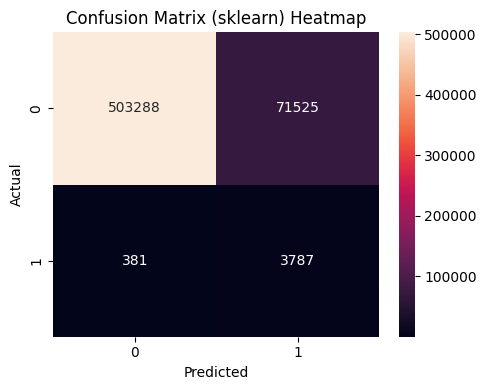

              precision    recall  f1-score   support

           0       1.00      0.88      0.93    574813
           1       0.05      0.91      0.10      4168

    accuracy                           0.88    578981
   macro avg       0.52      0.89      0.51    578981
weighted avg       0.99      0.88      0.93    578981



In [394]:
from sklearn.metrics import confusion_matrix ,classification_report
confusion_matrix_sklearn = confusion_matrix(np.ravel(y_test), y_pred)
confusion_matrix_sklearn
# Visualized the sklearn confusion matrix via heatmap
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix_sklearn, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (sklearn) Heatmap")

plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred))
from sklearn.metrics import roc_curve, roc_auc_score


In [377]:

# Predictions on training and test sets
y_train_pred = pipeline.predict(X_train_resampled)
y_test_pred = pipeline.predict(X_test_before)

# Calculate precision, recall, and F1-score on both sets
precision_train = precision_score(y_train_resampled, y_train_pred)
recall_train = recall_score(y_train_resampled, y_train_pred)
f1_train = f1_score(y_train_resampled, y_train_pred)

precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

print("Training Set:")
print(f"Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1-score: {f1_train:.4f}")
print("Test Set:")
print(f"Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1-score: {f1_test:.4f}")

Training Set:
Precision: 0.9928, Recall: 0.9918, F1-score: 0.9923
Test Set:
Precision: 0.0503, Recall: 0.9086, F1-score: 0.0953


### 5.5 ROC curve

In [378]:
# Call the model from pipeline
pipeline['prediction']

RandomForestClassifier(n_estimators=300)

In [379]:
# Get predicted class probabilities for the test set 
y_pred_pro_test = pipeline.predict_proba(X_test_before)[:, 1]
y_pred_prob_train = pipeline.predict_proba(X_train_resampled)[:, 1]

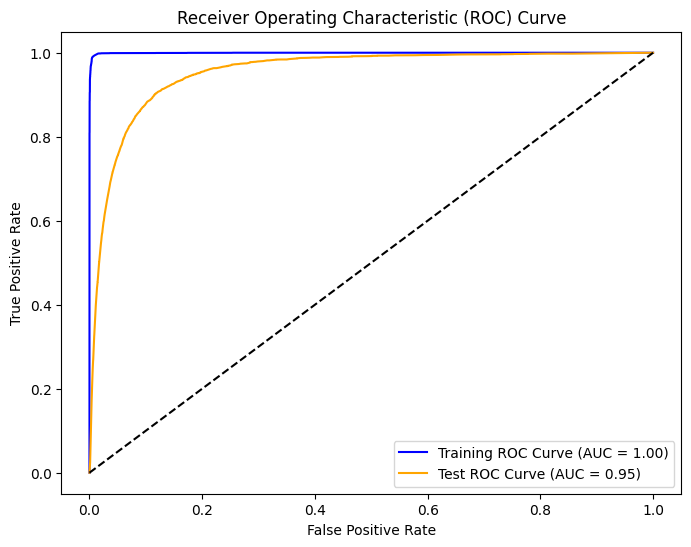

In [380]:
# Compute ROC curve and its corresponding values for both training and test sets
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_resampled, y_pred_prob_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_pro_test)
# Calculate the Area Under the ROC Curve (AUC) for both training and test sets
auc_train = roc_auc_score(y_train_resampled, y_pred_prob_train)
auc_test = roc_auc_score(y_test, y_pred_pro_test)
# Plot ROC curves for both training and test sets on the same plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Training ROC Curve (AUC = {auc_train:.2f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {auc_test:.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--')  # Plotting the diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## 6. Features Importance

In [381]:
# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print (best_estimator,best_params)

RandomForestClassifier(max_depth=20, n_estimators=300) {'max_depth': 20, 'n_estimators': 300}


In [382]:
# Get feature importances from the best estimator
feature_importances = best_estimator.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]
print(indices)

[ 0  4  5  6 11 10  3  1  7  2 12  9 13 15 16  8 17 14]


In [383]:
# Print feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. Feature {X_train_resampled.columns[indices[f]]} ({feature_importances[indices[f]]})")

Feature ranking:
1. Feature national_inv (0.38636345859158033)
2. Feature sales_3_month (0.08541356088272924)
3. Feature sales_6_month (0.07583105156504956)
4. Feature sales_9_month (0.06994565222154463)
5. Feature perf_12_month_avg (0.06768362638960856)
6. Feature perf_6_month_avg (0.06591535473343664)
7. Feature sales_1_month (0.06370110243941364)
8. Feature lead_time (0.04538693105441243)
9. Feature min_bank (0.0448577557244351)
10. Feature in_transit_qty (0.03640946163676626)
11. Feature local_bo_qty (0.018105520074582663)
12. Feature pieces_past_due (0.014849260188532644)
13. Feature deck_risk (0.011479990054044455)
14. Feature ppap_risk (0.00973901398414089)
15. Feature stop_auto_buy (0.003856896614828398)
16. Feature potential_issue (0.0002848990304720494)
17. Feature rev_stop (0.00016570905140772941)
18. Feature oe_constraint (1.0755763014896633e-05)


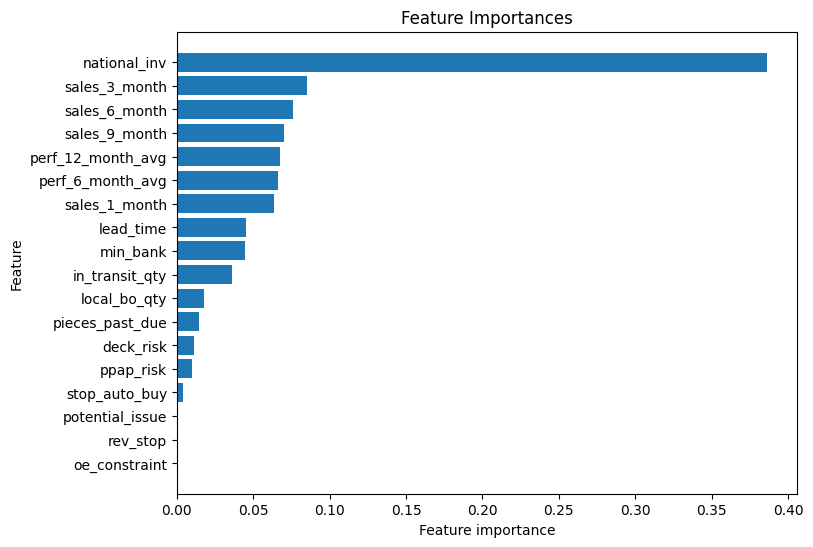

In [384]:
# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(range(X_train_resampled.shape[1], 0, -1), feature_importances[indices], align="center")
plt.yticks(range(X_train_resampled.shape[1], 0, -1), X_train_resampled.columns[indices])
plt.ylabel("Feature")
plt.xlabel("Feature importance")
plt.title("Feature Importances")
plt.show()

## 7. Inference

In [385]:
# Save the pipeline using joblib
joblib.dump(pipeline, 'pipeline_model.joblib')

['pipeline_model.joblib']

In [386]:
# Load the saved pipeline
loaded_pipeline = joblib.load('pipeline_model.joblib')

# Make predictions using the loaded pipeline
predictions = loaded_pipeline.predict(X_test_before)

accuracy_inference = loaded_pipeline.score(X_test_before, y_test)
print(f"Accuracy in inference: {accuracy_inference:.4f}")

Accuracy in inference: 0.8758


In [387]:
# Extract a single sample and convert it to a DataFrame
single_sample = X_test_before.iloc[100]  # Assuming this is a single row of your test data
single_sample_df = pd.DataFrame([single_sample], columns=X_test_before.columns)

In [388]:
single_sample

national_inv         262.0
lead_time             52.0
in_transit_qty         0.0
sales_1_month          3.0
sales_3_month          9.0
sales_6_month         40.0
sales_9_month         59.0
min_bank               2.0
potential_issue         No
pieces_past_due        0.0
perf_6_month_avg       0.0
perf_12_month_avg      0.0
local_bo_qty           0.0
deck_risk              Yes
oe_constraint           No
ppap_risk               No
stop_auto_buy          Yes
rev_stop                No
Name: 1766297, dtype: object

In [389]:
# # Make predictions using the loaded pipeline on the single sample
pred_test = loaded_pipeline.predict(single_sample_df)

# Mapping the predicted values (0 or 1)
pred_test_mapped = ['No' if pred == 0 else 'Yes' for pred in pred_test]
print(f'This product can potentially be a backorder?: {pred_test_mapped[0]}')

This product can potentially be a backorder?: No
